# Notebook Imports

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

%matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

## Constants

In [3]:
FILE = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

# Step 1: Data Collection and Loading

* Large Movie Review Dataset [Link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

In [4]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df_full.drop([0], axis=0, inplace=True)
df_full.reset_index(drop=True, inplace=True)

df = df_full.sample(frac=0.3)
df.head()

,review,sentiment
38142,I'm a next generation person...i've never saw ...,positive
1800,I can never fathom why people take time to rev...,positive
1108,I have not read the book that this was based u...,positive
35226,"This movie isn't very good. It's boring, and n...",negative
26712,Hood of the Living Dead and all of the other m...,negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 38142 to 40380
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     15000 non-null  object
 1   sentiment  15000 non-null  object
dtypes: object(2)
memory usage: 351.6+ KB


In [6]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
review       0
sentiment    0
dtype: int64


In [7]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")


The shape of the data: (15000, 2)

The types of the data: 
review       object
sentiment    object
dtype: object



# Step 2: Data Preprocessing

* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.

### Text Cleaning

In [8]:
df.nunique()

review       14967
sentiment        2
dtype: int64

In [9]:
df = df.drop_duplicates()
print(df.shape)
df.head()

(14967, 2)


,review,sentiment
38142,I'm a next generation person...i've never saw ...,positive
1800,I can never fathom why people take time to rev...,positive
1108,I have not read the book that this was based u...,positive
35226,"This movie isn't very good. It's boring, and n...",negative
26712,Hood of the Living Dead and all of the other m...,negative


In [10]:
# remove html tags from text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

### Tokenization, Stop Words Removal, Lemmatization

In [11]:
def clean_review(text, wl=WordNetLemmatizer(), 
               stop_words=set(stopwords.words('english'))):
    # Remove HTML tags
    cleaned_text = remove_html_tags(text)
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(wl.lemmatize(word))
    
    filtered_words = ' '.join(filtered_words)    
     
    return filtered_words

In [12]:
%%time
nested_list = df.review.apply(clean_review)
df['review'] = nested_list

CPU times: user 1min 4s, sys: 174 ms, total: 1min 5s
Wall time: 1min 5s


In [13]:
df.head()

,review,sentiment
38142,next generation person never saw original doct...,positive
1800,never fathom people take time review movie und...,positive
1108,read book based others film role last work joh...,positive
35226,movie good boring much blood horror film plot ...,negative
26712,hood living dead movie guy directed look like ...,negative


In [14]:
nested_list.head()

38142    next generation person never saw original doct...
1800     never fathom people take time review movie und...
1108     read book based others film role last work joh...
35226    movie good boring much blood horror film plot ...
26712    hood living dead movie guy directed look like ...
Name: review, dtype: object

In [15]:
label_encoder = LabelEncoder() 
df['category']= label_encoder.fit_transform(df['sentiment']) 

df.head()

,review,sentiment,category
38142,next generation person never saw original doct...,positive,1
1800,never fathom people take time review movie und...,positive,1
1108,read book based others film role last work joh...,positive,1
35226,movie good boring much blood horror film plot ...,negative,0
26712,hood living dead movie guy directed look like ...,negative,0


### Positive and Negative Words

In [16]:
# Identify the index of positive review
ids_positive = df[df.category == 1].index
ids_positive

Index([38142,  1800,  1108,  5021,  3127, 47266,  1190, 30621, 46287, 42895,
       ...
       46684, 23102, 39703, 18336,  2843,  9444, 44779, 49883,  6038, 28322],
      dtype='int64', length=7482)

In [17]:
# Identify the index of negative review
ids_negative = df[df.category == 0].index
ids_negative

Index([35226, 26712, 11473, 28556,  4189, 43365, 49167, 19077, 36953, 28963,
       ...
       12198, 40865, 33946, 37894, 26316,  2591,  4437,  7883, 15237, 40380],
      dtype='int64', length=7485)

In [18]:
nested_list_positive = nested_list.loc[ids_positive]
nested_list_negative = nested_list.loc[ids_negative]

nested_list_positive.shape, nested_list_negative.shape

((7482,), (7485,))

In [19]:
list_positive = [item for sublist in nested_list_positive for item in sublist.split(" ")]
positive_words = pd.Series(list_positive).value_counts()

list_negative = [item for sublist in nested_list_negative for item in sublist.split(" ")]
negative_words = pd.Series(list_negative).value_counts()

positive_words.shape[0], negative_words.shape[0]

(39478, 37647)

In [20]:
positive_words[:10]

film         14430
movie        12994
one           8140
like          5296
time          4497
good          4333
story         4151
character     4036
great         3779
see           3693
Name: count, dtype: int64

In [21]:
negative_words[:10]

movie        17125
film         12308
one           7640
like          6638
even          4574
would         4505
time          4303
bad           4289
good          4165
character     4065
Name: count, dtype: int64

# Step 3: Exploratory Data Analysis (EDA)

* Visualize the distribution of reviews by sentiment (positive vs. negative)
* Analyze the most common words in positive and negative reviews

In [22]:
amount_of_positive_review = df.category.value_counts()[1]
amount_of_negative_review = df.category.value_counts()[0]

amount_of_positive_review, amount_of_negative_review

(7482, 7485)

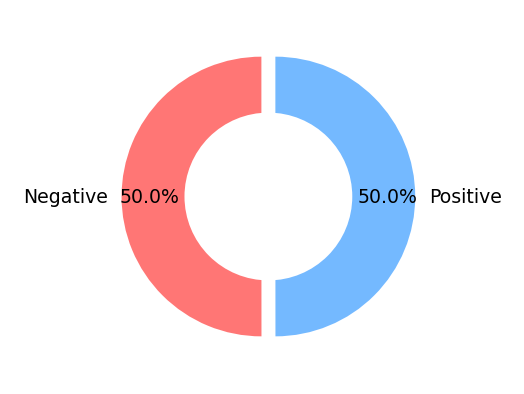

In [23]:
categoty_names = ['Negative', 'Positive']
sizes = [amount_of_negative_review, amount_of_positive_review]
custom_colours = ['#ff7675', '#74b9ff']
offset = [0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

#draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

### Word Cloud of Positive and Negative Reviews

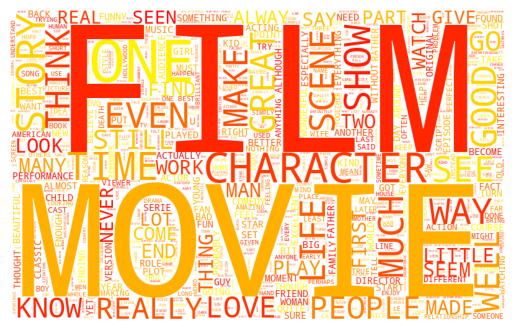

In [24]:
# Generate the text as a string for the Word Cloud
positive_str = ' '.join(list_positive)

wc = WordCloud(background_color='white', max_words=1000, colormap='autumn', width=800, height=500)
wc.generate(positive_str.upper())
plt.axis("off")
plt.imshow(wc)

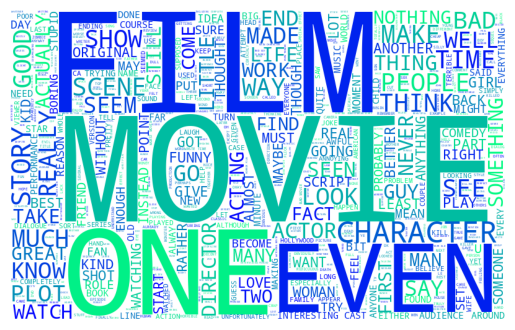

In [25]:
# Generate the text as a string for the Word Cloud
negative_str = ' '.join(list_negative)

wc = WordCloud(background_color='white', max_words=1000, colormap='winter', width=800, height=500)
wc.generate(negative_str.upper())
plt.axis("off")
plt.imshow(wc)

# Step 5: Model Preparation

In [26]:
max_length = max(len(sublist) for sublist in nested_list)
print(max_length)

6109


In [27]:
df.reset_index()
df.head()

,review,sentiment,category
38142,next generation person never saw original doct...,positive,1
1800,never fathom people take time review movie und...,positive,1
1108,read book based others film role last work joh...,positive,1
35226,movie good boring much blood horror film plot ...,negative,0
26712,hood living dead movie guy directed look like ...,negative,0


In [28]:
data_dict = {
    "Preprocessed Review": df['review'],
    "Target": df['category']
}

df_prep = pd.DataFrame(data_dict)
df_prep.head()

,Preprocessed Review,Target
38142,next generation person never saw original doct...,1
1800,never fathom people take time review movie und...,1
1108,read book based others film role last work joh...,1
35226,movie good boring much blood horror film plot ...,0
26712,hood living dead movie guy directed look like ...,0


In [29]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_prep['Preprocessed Review']).toarray()
y = np.array(df_prep['Target'].values, dtype='float64')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(11973, 2994, 11973, 2994)

In [31]:
LABELS = ['0', '1']

In [32]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix using the true and predicted labels.

    Args:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.
        labels (array-like): The list of labels to index the matrix.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Step 5: Model Training & Evaluation

## Logistic Regression

In [33]:
logreg = LogisticRegression(random_state=42)

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

accuracy_score(y_test, y_pred_lr)

0.8674014696058784

In [34]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86      1476
         1.0       0.86      0.89      0.87      1518

    accuracy                           0.87      2994
   macro avg       0.87      0.87      0.87      2994
weighted avg       0.87      0.87      0.87      2994



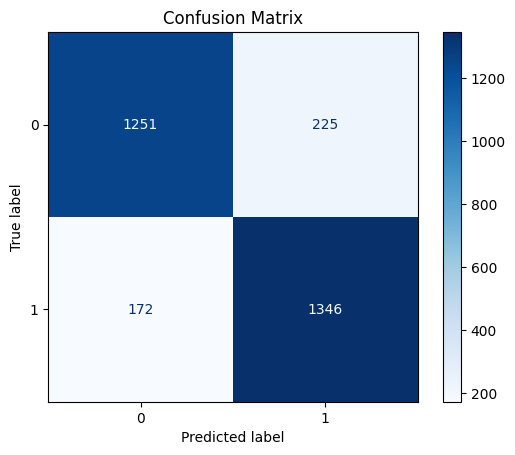

In [35]:
plot_confusion_matrix(y_test, y_pred_lr, LABELS)

## Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred_dt = model.predict(X_test)

accuracy_score(y_test, y_pred_dt)

0.6957247828991316

In [37]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.69      0.70      0.70      1476
         1.0       0.71      0.69      0.70      1518

    accuracy                           0.70      2994
   macro avg       0.70      0.70      0.70      2994
weighted avg       0.70      0.70      0.70      2994



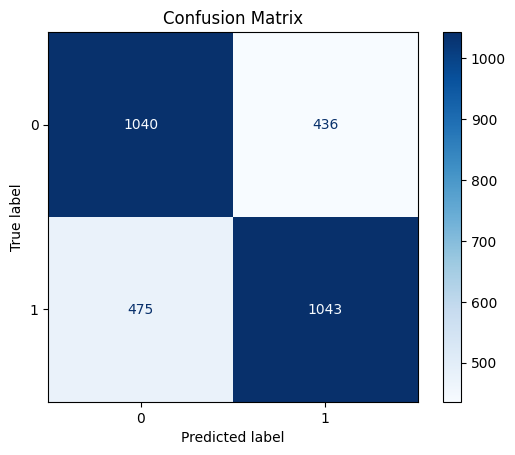

In [38]:
plot_confusion_matrix(y_test, y_pred_dt, LABELS)

## Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)

accuracy_score(y_test, y_pred_rf)

0.8333333333333334

In [40]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83      1476
         1.0       0.85      0.82      0.83      1518

    accuracy                           0.83      2994
   macro avg       0.83      0.83      0.83      2994
weighted avg       0.83      0.83      0.83      2994



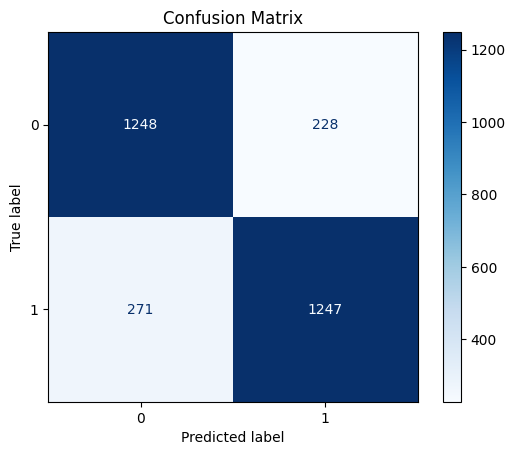

In [41]:
plot_confusion_matrix(y_test, y_pred_rf, LABELS)